In [1]:
import sys, os
sys.path.append(os.path.realpath("/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages"))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd


reload(read)

edfRawData = read.EdfDataset("train", "01_tcp_ar", n_process=7)
edfFFTData = read.EdfFFTDatasetTransformer(edfRawData, window_size=pd.Timedelta(seconds=10), precache=False, n_process=7)

In [2]:
import multiprocessing as mp
mp.cpu_count()

32

In [3]:
data = edfRawData[0:21]

Starting 7 processes
retrieving: 0


In [75]:
fftData = edfFFTData[0:20]

Starting 7 processes
retrieving: 0
retrieving: 1
retrieving: 2
retrieving: 3
retrieving: 4
retrieving: 6
retrieving: 5
retrieving: 7
retrieving: 8
retrieving: 9
retrieving: 10
retrieving: 11
retrieving: 12
retrieving: 13
retrieving: 14
retrieving: 15
retrieving: 16
retrieving: 17
retrieving: 18
retrieving: 19


In [13]:
len([0.2 * i for i in range(50)] + list(range(10, 50, 1)) + list(range(50,400, 20)))

108

In [100]:
fftData[0][0].shape

(30, 1305, 99)

In [15]:
333847/1305

255.8214559386973

In [5]:
data[0][0].index.max() / pd.Timedelta(seconds=1/256)

334101.0

In [23]:
original_data = data[0]

In [10]:
import numpy as np

In [21]:
original_data

(                 EEG FP1-REF  EEG FP2-REF  EEG F3-REF  EEG F4-REF  EEG C3-REF  \
 00:00:00          -44.552129   -87.124117   28.232238   -4.116370   34.335749   
 00:00:00.003906   -46.688358   -85.750827   27.316711   -5.642248   34.030573   
 00:00:00.007812   -50.808228   -94.143155   26.706360  -10.525056   32.809871   
 00:00:00.011718   -50.045289   -97.042323   25.333070  -16.781155   32.962459   
 00:00:00.015624   -51.876342   -96.584559   24.722719  -15.102689   33.420222   
 00:00:00.019530   -55.385861  -101.925131   18.771796  -16.628567   28.690001   
 00:00:00.023436   -55.996212   -91.396575   26.096009  -16.628567   30.826230   
 00:00:00.027342   -54.622922   -97.957849   15.872628  -11.593171   34.335749   
 00:00:00.031248   -53.859983  -111.538161   25.485658  -32.955459   36.624565   
 00:00:00.035154   -63.167837  -120.235664   19.992498  -19.222559   35.861626   
 00:00:00.039060   -63.625601  -121.151190   21.976139  -23.342429   41.049610   
 00:00:00.042966

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras import backend as K

In [ ]:
import pyedflib

In [10]:
pyedflib.

1

In [6]:
fftData[0][0].shape

(30, 1305, 107)

In [16]:
len(fftData)

20

In [18]:
[fftData[i][0].shape[1] for i in range(19)]

[300,
 300,
 300,
 300,
 601,
 601,
 300,
 601,
 89,
 25,
 601,
 601,
 186,
 601,
 601,
 601,
 1305,
 744,
 601]

In [80]:
num_files = 50
n_process = 8
latent_dim = 100
freq_bins = read.EdfFFTDatasetTransformer.freq_bins
input_shape = 21 * (len(freq_bins) - 1) #num channels times number of freq bins we extrapolated out
window_size = 10 #seconds
non_overlapping = True

In [91]:
encoder_inputs = Input(shape=(None, input_shape))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, input_shape))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(input_shape, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], [decoder_outputs, state_h, state_c])
model.compile(optimizer='rmsprop', loss=['categorical_crossentropy', None, None])


In [88]:
datum = (fftData[0][0]).transpose((1, 0,2)).reshape(1, fftData[0][0].shape[1], -1)

In [89]:
datum.shape

(1, 30, 2247)

In [99]:
output = model.fit([datum, datum], datum)

W0625 13:41:18.100662 140303654815552 deprecation.py:323] From /home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
1/1 [==============================] - 7s 7s/step - loss: 400030990336.0000 - dense_8_loss: 400030990336.0000


In [97]:
output[0].shape

(1, 100)

In [79]:
2268/21

108.0

In [ ]:
import seq_2_seq_exp as s2s
reload(s2s)

Using TensorFlow backend.


In [4]:
reload(read)
s2sdata = read.Seq2SeqFFTDataset(edfFFTData, n_process=4)

In [6]:
fftData, ann = s2sdata.edfFFTData[0]

In [7]:
s2sdata[0]

(array([[[2.95480510e+08, 1.47656730e+08, 1.27279827e+08, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.78655712e+07, 5.09991516e+06, 2.67267681e+06, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.30652480e+07, 1.11915807e+06, 6.93337845e+05, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [4.11501598e+07, 5.04477602e+05, 6.00412903e+05, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.09881520e+07, 2.98734322e+06, 1.94415506e+06, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.52794732e+07, 6.95912337e+06, 3.47984409e+06, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]),
                  null  spsw  gped  pled  eybl  artf  bckg  seiz  fnsz  gnsz  \
 00:00:00          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
 00:00:09.999360   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
 00:00:19.9

In [8]:
s2sData = s2sdata[0]

In [9]:
s2sData.shape #time steps, fft shape

(130, 2247)

In [112]:
(fftData).transpose((1, 0,2)).reshape(1, fftData.shape[1], -1)

array([[[4.34037885e+09, 1.03454610e+09, 5.90242651e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.09711430e+09, 5.81356170e+07, 6.48893937e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.58080391e+08, 2.80900193e+07, 1.82131839e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [6.57933160e+08, 2.80303267e+07, 1.81607134e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.09642163e+09, 5.84037031e+07, 6.51503248e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.33045677e+09, 1.03113558e+09, 5.85774753e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])

In [10]:
data = s2sdata[0:4]

Starting 4 processes
retrieving: 0
retrieving: 1
retrieving: 2
retrieving: 3


In [25]:
reader = pyedflib.EdfReader("/home/ms994/v1.5.0/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/00011333_s012_t006.edf")

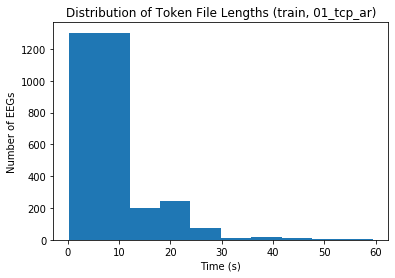

In [49]:
import matplotlib.pyplot as plt
plt.hist(pd.read_csv("times.csv", header=None)[1]/60)
plt.title("Distribution of Token File Lengths (train, 01_tcp_ar)")
plt.xlabel("Time (s)")
plt.ylabel("Number of EEGs")
plt.show()

In [5]:
times = pd.read_csv("../times.csv", header=None)[1]

FileNotFoundError: [Errno 2] File b'../times.csv' does not exist: b'../times.csv'

In [23]:
data[2].shape

(30, 2247)

In [5]:
len(read.get_all_token_file_names("train", "01_tcp_ar"))

3177

In [3]:
import pickle as pkl
pickleData = pkl.load(open("s2s_train_01_tcp_ar_fft.pkl", 'rb'))

In [3]:
import numpy as np
[datum.shape[1] for datum in pickleData[1]]

NameError: name 'pickleData' is not defined

In [2]:
1659 / 21

79.0